# Expectation model plots

## Preliminaries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns
from scipy.stats import norm
import statsmodels.formula.api as smf

sns.set_context("talk")

## Load data

In [2]:
# Load synonymous variant data, and get the proportion observed
df = pd.read_csv("../outputs/observed_variants_stats_synonymous.tsv", sep="\t").assign(
    p_obs=lambda x: x["obs"] / x["pos"]
)

# Exclude saturated variant contexts
non_sat = df[df["p_obs"] != 1].copy()

# Separate CpG transitions and non CpG transitions
non_cpg = df[df["variant_type"] != "CpG"].copy()
cpg = df[df["variant_type"] == "CpG"].copy()

## Expectation models

### CpG and non-CpG combined

In [3]:
combined_model = smf.wls(
    "np.log(1 - non_sat['p_obs']) ~ mu",
    data=non_sat,
    weights= non_sat["pos"],
).fit()
combined_model.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 WLS Regression Results                                 
========================================================================================
Dep. Variable:     np.log(1 - non_sat['p_obs'])   R-squared:                       0.979
Model:                                      WLS   Adj. R-squared:                  0.979
No. Observations:                           299   F-statistic:                 1.391e+04
Covariance Type:                      nonrobust   Prob (F-statistic):          1.69e-251
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -0.0384      0.003    -11.732      0.000      -0.045      -0.032
mu         -2.256e+07   1.91e+05   -117.940      0.000   -2.29e+07   -2.22e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 6.35e+07. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### Non-CpG

#### Model proportion observed by mutability

In [4]:
non_cpg_mu_model = smf.wls("p_obs ~ mu", data=non_cpg, weights=non_cpg["pos"]).fit()
non_cpg_mu_model.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                  p_obs   R-squared:                       0.959
Model:                            WLS   Adj. R-squared:                  0.959
No. Observations:                 176   F-statistic:                     4083.
Covariance Type:            nonrobust   Prob (F-statistic):          9.71e-123
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0121      0.002      5.790      0.000       0.008       0.016
mu          2.574e+07   4.03e+05     63.897      0.000    2.49e+07    2.65e+07
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 3.56e+08. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Model proportion expected on proportion observed

In [5]:
non_cpg_obs_model = smf.ols(
    "non_cpg_mu_model.predict(non_cpg['mu']) ~ p_obs", data=non_cpg
).fit()
non_cpg_obs_model.summary(slim=True)

<class 'statsmodels.iolib.summary.Summary'>
"""
                                       OLS Regression Results                                      
===================================================================================================
Dep. Variable:     non_cpg_mu_model.predict(non_cpg['mu'])   R-squared:                       0.951
Model:                                                 OLS   Adj. R-squared:                  0.951
No. Observations:                                      176   F-statistic:                     3372.
Covariance Type:                                 nonrobust   Prob (F-statistic):          7.84e-116
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0063      0.002      3.011      0.003       0.002       0.010
p_obs          0.9581      0.016     58.067      0.000       0.926       0.991
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

/home/alex/miniconda3/ukb/lib/python3.8/site-packages/pandas/core/arraylike.py:402: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


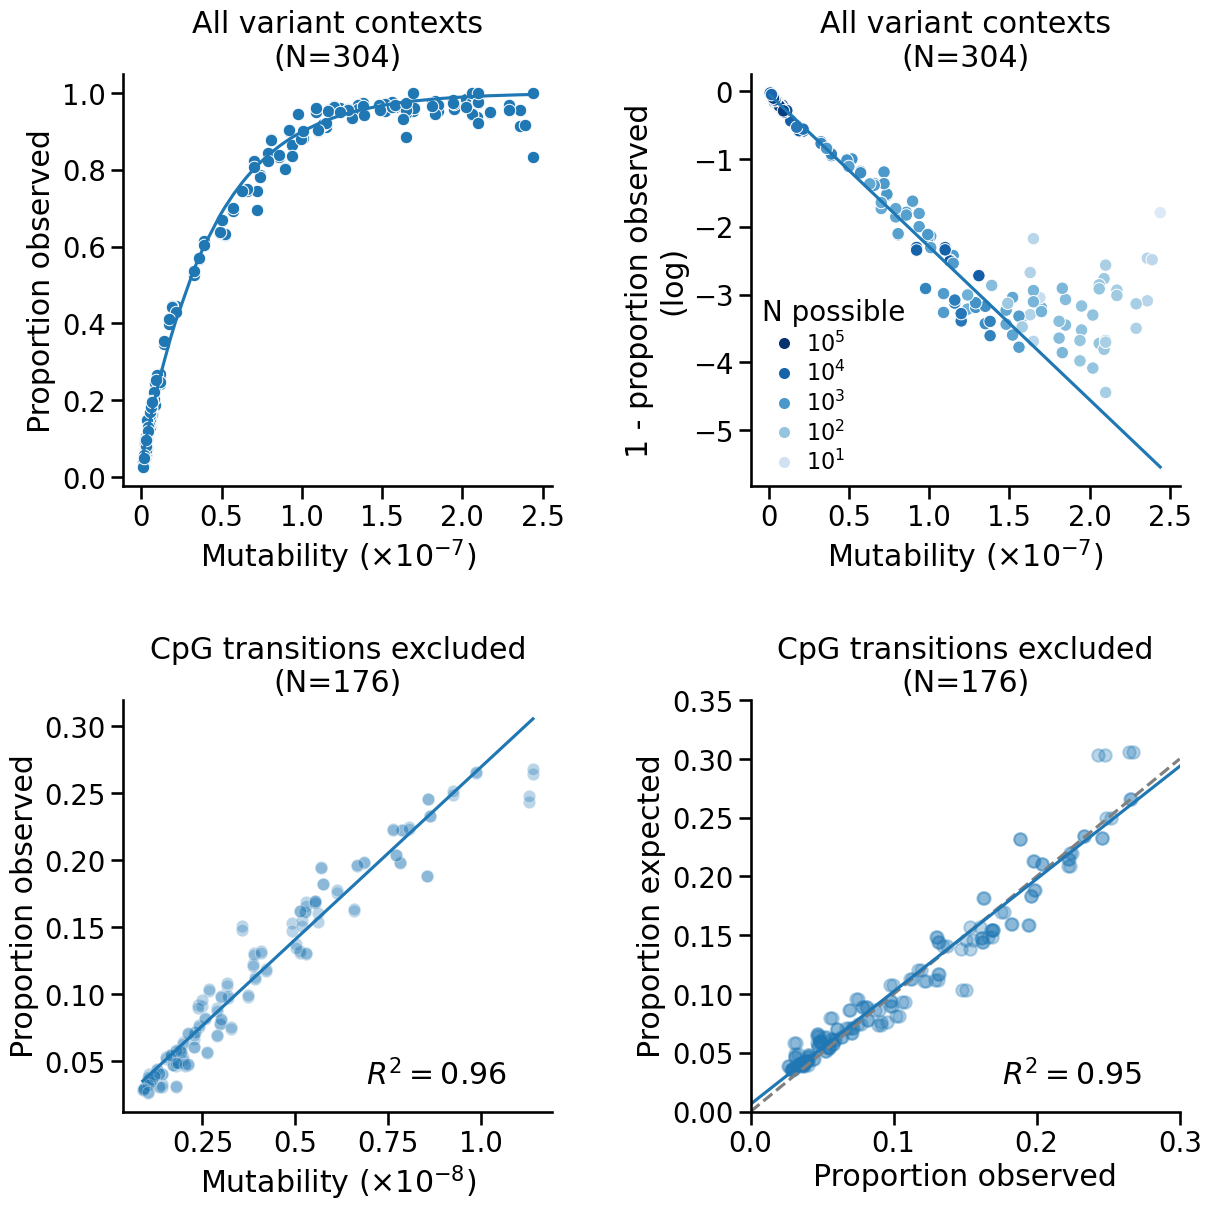

In [11]:
sns.set_context("talk", font_scale=1.2)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(
    2, 2, figsize=(12, 12), layout="constrained"
)

# Axes 1
sns.scatterplot(
    ax=ax1,
    data=df,
    x=df["mu"],
    y=df["p_obs"],
)
ax1.set_ylabel("Proportion observed")
ax1.set_title("All variant contexts\n(N=304)")
ax1.set_xlabel(r"Mutability ($\times 10^{-7}$)")
ax1.set_xticks(
    [0, 5 * 10**-8, 10**-7, 1.5 * 10**-7, 2 * 10**-7, 2.5 * 10**-7]
)
ax1.set_xticklabels([0, 0.5, 1.0, 1.5, 2.0, 2.5])

## Add a regression line to ax1
ax1.plot(
    non_sat.sort_values("mu")["mu"], 1 - np.exp(combined_model.predict(non_sat.sort_values("mu")))
)

# Axes 2
sns.scatterplot(
    ax=ax2,
    data=df,
    x=df["mu"],
    y=np.log(1 - df["p_obs"]),
    hue=np.log10(df["pos"]),
    hue_norm=(0, max(np.log10(df["pos"]))),
    palette="Blues",
)
ax2.set_ylabel("1 - proportion observed\n(log)")
ax2.set_title("All variant contexts\n(N=304)")
ax2.set_xlabel(r"Mutability ($\times 10^{-7}$)")
ax2.set_xticks(
    [0, 5 * 10**-8, 10**-7, 1.5 * 10**-7, 2 * 10**-7, 2.5 * 10**-7]
)
ax2.set_xticklabels([0, 0.5, 1.0, 1.5, 2.0, 2.5])

## Add regression line to Axes 2
ax2.plot(
    non_sat.sort_values("mu")["mu"], combined_model.predict(non_sat.sort_values("mu"))
)

## Axes 2 legend
cmap = plt.cm.Blues
legend_elements = [
    Line2D([0], [0], marker="o", color="w", markerfacecolor=cmap(0.2), label="$10^1$"),
    Line2D([0], [0], marker="o", color="w", markerfacecolor=cmap(0.4), label="$10^2$"),
    Line2D([0], [0], marker="o", color="w", markerfacecolor=cmap(0.6), label="$10^3$"),
    Line2D([0], [0], marker="o", color="w", markerfacecolor=cmap(0.8), label="$10^4$"),
    Line2D([0], [0], marker="o", color="w", markerfacecolor=cmap(0.99), label="$10^5$"),
]

ax2.legend(
    title="N possible",
    handles=legend_elements[::-1],
    frameon=False,
    alignment="left",
    labelspacing=0.2,
    handletextpad=0,
    title_fontsize=20,
    fontsize=16,
    loc="lower left",
    borderpad=0,
)

# Axes 3
sns.scatterplot(
    ax=ax3,
    data=df[df.variant_type != "CpG"],
    x="mu",
    y=df["obs"] / df["pos"],
    alpha=0.3,
)
ax3.set_ylabel("Proportion observed")
ax3.set_title("CpG transitions excluded\n(N=176)")
ax3.set_xlabel(r"Mutability ($\times 10^{-8}$)")
ax3.set_xticks([0, 2.5 * 10**-9, 5 * 10**-9, 7.5 * 10**-9, 1 * 10**-8])
ax3.set_xticklabels(
    [
        0,
        0.25,
        0.5,
        0.75,
        1.0,
    ]
)

## Add a regression line to ax3
x1 = min(non_cpg["mu"])
x2 = max(non_cpg["mu"])
y1 = non_cpg_mu_model.params.mu * x1 + non_cpg_mu_model.params.Intercept
y2 = non_cpg_mu_model.params.mu * x2 + non_cpg_mu_model.params.Intercept

ax3.plot([x1, x2], [y1, y2])

# Axes 4
ax4.scatter(x=non_cpg["p_obs"], y=non_cpg_mu_model.predict(non_cpg["mu"]), alpha=0.3)
ax4.set_xlabel("Proportion observed")
ax4.set_ylabel("Proportion expected")
ax4.set_title("CpG transitions excluded\n(N=176)")
ax4.axline([0, 0], [1, 1], color="grey", linestyle="--")
ax4.axline(
    xy1=(0, non_cpg_obs_model.params.Intercept), slope=non_cpg_obs_model.params.p_obs
)
ax4.set_xlim(0, 0.30)
ax4.set_ylim(0, 0.35)
ax4.spines["top"].set_color("None")
ax4.spines["right"].set_color("None")

# Figure
for ax in ax1, ax2, ax3, ax4:
    ax.spines["top"].set_color("None")
    ax.spines["right"].set_color("None")

fig.get_layout_engine().set(wspace=0.1, hspace=0.1)
fig.text(x=0.3, y=0.1, s=rf"$R^2 = {np.round(non_cpg_mu_model.rsquared,2)}$")
fig.text(x=0.83, y=0.1, s=rf"$R^2 = {np.round(non_cpg_obs_model.rsquared,2)}$")

plt.savefig("../plots/expectation_model_by_cpg.svg", format="svg")